<img src="https://visme.co/blog/wp-content/uploads/climate-change-facts-header-wide.gif">

# It's Only A Matter of Time* 

 #### **Authors:**  Jiji Craynock & Rafael Ferreira 

<a name="overview"></a>  
## Overview
A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Table of Contents 

1. [Overview](#overview) 
2. [Business Problem](#business_problem)
3. [Data_Understanding](#data_understanding) 
4. [Data Preperation](#data_preparation)
    1. [Preprocessing](#preprocessing) 
    2. [Exploratory Data Analysis](#EDA) 
    3. [Model Preperation](#model_preperation) 
5. [Data Modeling](#data_modeling)   
6. [Evaluation](#evaluation)    
7. [Conclusion](#conclusion)  

<a name="business_problem"></a> 

## Business Problem
Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

What are the business's pain points related to this project?
How did you pick the data analysis question(s) that you did?
Why are these questions important from a business perspective?

<a name="data_understanding"></a> 
## Data Understanding
Describe the data being used for this project.

Questions to consider:

Where did the data come from, and how do they relate to the data analysis questions?
What do the data represent? Who is in the sample and what variables are included?
What is the target variable?
What are the properties of the variables you intend to use?

<a name="data_preparation"></a> 
## Data Preparation
Describe and justify the process for preparing the data for analysis.

Questions to consider:

Were there variables you dropped or created?
How did you address missing values or outliers?
Why are these choices appropriate given the data and the business problem? 

<a name="preprocessing"></a> 
### Preprocessing 

In [1]:
#Import necessary packages
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
#Load data and print summary statistics
weekly = pd.read_csv('co2_weekly_mlo.csv') 
weekly.describe()

,year,month,day,decimal,average,ndays,1 year ago,10 years ago,increase since 1800
count,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000
mean,1997.259730,6.535846,15.719787,1997.760793,357.912372,5.868906,327.778267,57.278693,79.991254
std,13.510793,3.451129,8.802066,13.507458,119.562459,1.372752,229.377689,564.495447,96.204762
min,1974.000000,1.000000,1.000000,1974.379500,-999.990000,0.000000,-999.990000,-999.990000,-999.990000
25%,1986.000000,4.000000,8.000000,1986.069900,346.980000,5.000000,345.490000,331.190000,66.900000
50%,1997.000000,7.000000,16.000000,1997.760300,364.870000,6.000000,363.120000,349.780000,84.130000
75%,2009.000000,10.000000,23.000000,2009.450700,387.580000,7.000000,385.760000,368.130000,107.690000
max,2021.000000,12.000000,31.000000,2021.141100,417.670000,7.000000,415.530000,393.670000,136.490000


In [3]:
#Check data for null values 
weekly.isna().sum()

year                   0
month                  0
day                    0
decimal                0
average                0
ndays                  0
1 year ago             0
10 years ago           0
increase since 1800    0
dtype: int64

In [4]:
#Make inital changes to data including: 
weekly['Date'] = pd.to_datetime(weekly[['year', 'month', 'day']])  #Creating a data column
weekly['average'] = weekly['average'].abs()  #Making all numbers in average column positive by changing them to absolute values
weekly['increase since 1800'] = weekly['increase since 1800'].abs()  #Making all numbers in increase since 1800 column positive by changing them to absolute values
weekly.drop(columns = ['decimal', '1 year ago', '10 years ago'], inplace = True) #Dropping unneeded columns 

Having done initial clean up, we now move on cleaning up the values in our averages column and increase since 1800 column. We discovered that while there are no missing values, the data collectors have filled in missing values with 999.99. These values will be addressed by using the average of the values for the index rows before and after the missing values. If multiple values in succession are missing the values for the index rows before and after the set of missing values.

In [5]:
#Look at which rows have 999.99 values or above the mean values for the increase since 1800 column
weekly1 = weekly[weekly['increase since 1800']> 500] 
weekly1

,year,month,day,average,ndays,increase since 1800,Date
72,1975,10,5,999.99,0,999.99,1975-10-05
81,1975,12,7,999.99,0,999.99,1975-12-07
82,1975,12,14,999.99,0,999.99,1975-12-14
83,1975,12,21,999.99,0,999.99,1975-12-21
84,1975,12,28,999.99,0,999.99,1975-12-28
110,1976,6,27,999.99,0,999.99,1976-06-27
409,1982,3,21,999.99,0,999.99,1982-03-21
412,1982,4,11,999.99,0,999.99,1982-04-11
413,1982,4,18,999.99,0,999.99,1982-04-18
481,1983,8,7,999.99,0,999.99,1983-08-07


In [6]:
#Replace the values with the average for the rows above and below the value(s) that need to changed
inc1975=weekly.loc[[71, 73], 'increase since 1800'].mean() 
weekly.loc[[72, 81, 82, 83, 84], 'increase since 1800'] = inc1975 

inc1976=weekly.loc[[109,111], 'increase since 1800'].mean() 
weekly.loc[[110], 'increase since 1800'] = inc1976 

inc1982=weekly.loc[[411, 414], 'increase since 1800'].mean() 
weekly.loc[[409, 412, 413], 'increase since 1800'] = inc1982 

inc1983=weekly.loc[[480, 482], 'increase since 1800'].mean() 
weekly.loc[[481], 'increase since 1800'] = inc1983

inc1984=weekly.loc[[514, 519], 'increase since 1800'].mean() 
weekly.loc[[515, 516, 517, 518], 'increase since 1800'] = inc1984

inc2005=weekly.loc[[1638, 1640], 'increase since 1800'].mean() 
weekly.loc[[1639], 'increase since 1800'] = inc2005 

inc2008=weekly.loc[[1779, 1783], 'increase since 1800'].mean() 
weekly.loc[[1780, 1781, 1782], 'increase since 1800'] = inc2008

In [7]:
#Look at which rows have 999.99 values or above the mean values for the average column
weekly2 = weekly[(weekly['average']> 500) | (weekly['average'] < 175)] 
weekly2

,year,month,day,average,ndays,increase since 1800,Date
72,1975,10,5,999.99,0,51.570,1975-10-05
81,1975,12,7,999.99,0,51.570,1975-12-07
82,1975,12,14,999.99,0,51.570,1975-12-14
83,1975,12,21,999.99,0,51.570,1975-12-21
84,1975,12,28,999.99,0,51.570,1975-12-28
110,1976,6,27,999.99,0,52.050,1976-06-27
409,1982,3,21,999.99,0,61.575,1982-03-21
412,1982,4,11,999.99,0,61.575,1982-04-11
413,1982,4,18,999.99,0,61.575,1982-04-18
481,1983,8,7,999.99,0,63.685,1983-08-07


In [8]:
#Replace the values with the average for the rows above and below the value(s) that need to changed for the average column
ppm1975=weekly.loc[[71, 85], 'average'].mean() 
weekly.loc[[72, 81, 82, 83, 84], 'average'] = ppm1975  

ppm1976=weekly.loc[[109, 111], 'average'].mean() 
weekly.loc[[110], 'average'] = ppm1976  

ppm1982=weekly.loc[[408, 414], 'average'].mean() 
weekly.loc[[409, 412, 413], 'average'] = ppm1982

ppm1983=weekly.loc[[480, 482], 'average'].mean() 
weekly.loc[[481], 'average'] = ppm1983

ppm1984=weekly.loc[[514, 519], 'average'].mean() 
weekly.loc[[515, 516, 517, 518], 'average'] = ppm1984

ppm2005=weekly.loc[[1638, 1640], 'average'].mean() 
weekly.loc[[1639], 'average'] = ppm2005

ppm2008=weekly.loc[[1779, 1783], 'average'].mean() 
weekly.loc[[1780, 1781, 1782], 'average'] = ppm2008

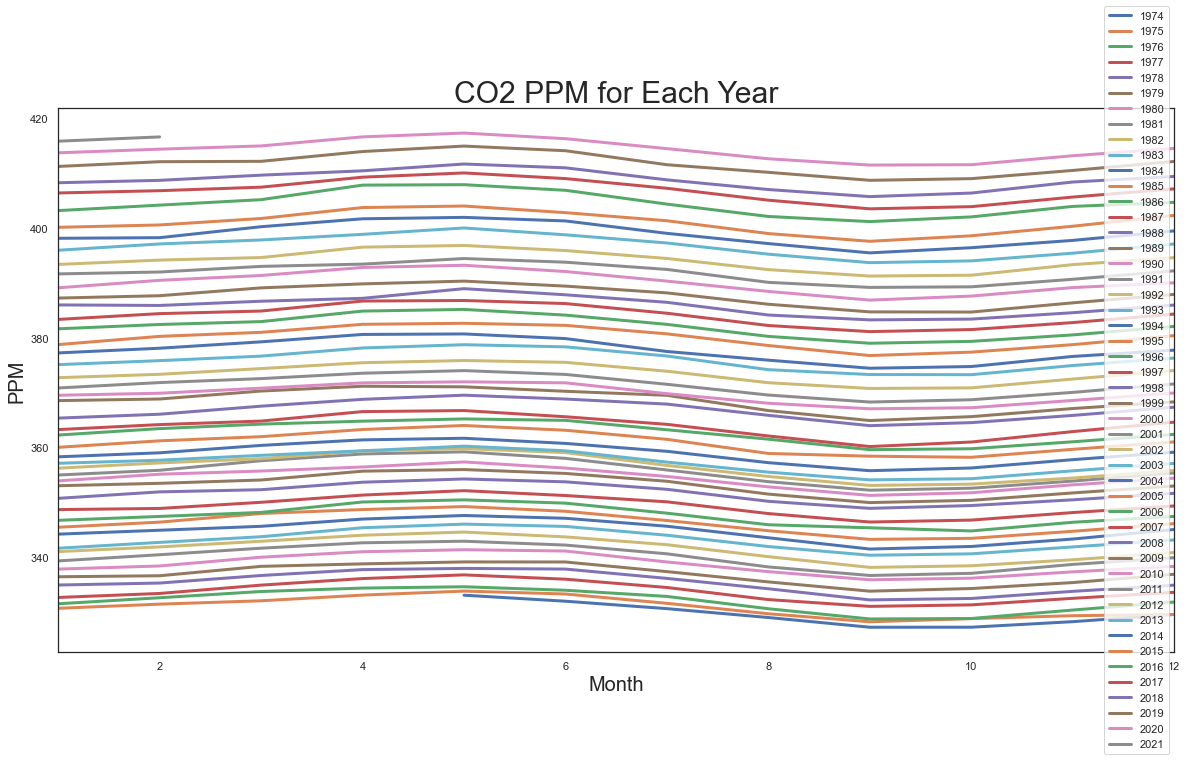

In [14]:
#Graph the average column to confirm outliers hav e been addressed
season = weekly
season['Date'] = weekly.Date
season['year'] = weekly['Date'].dt.year
season['month'] = weekly['Date'].dt.month
spivot = pd.pivot_table(season, index='month', columns = 'year', values = 'average', aggfunc=np.mean)
spivot.plot(figsize=(20,10), linewidth=3)
plt.legend(loc = 'right')
plt.title('CO2 PPM for Each Year', fontsize = 30)
plt.ylabel('PPM', fontsize = 20) 
plt.xlabel('Month', fontsize = 20)
plt.show()

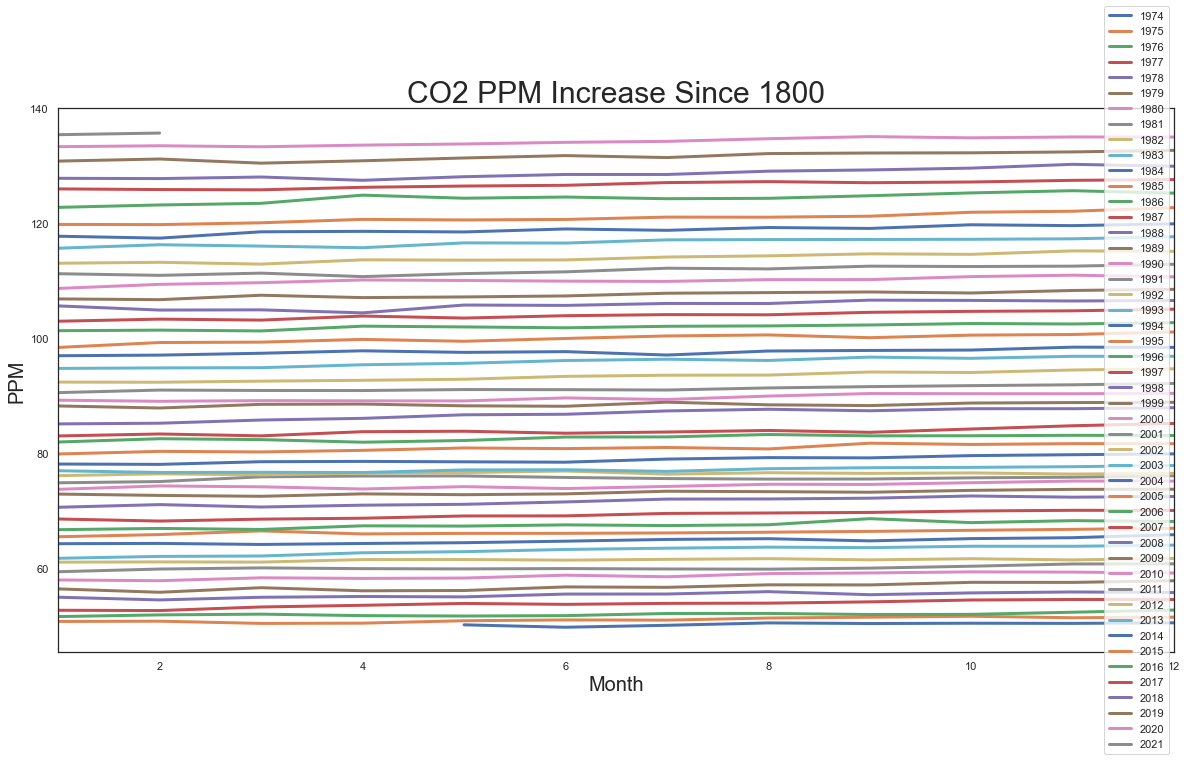

In [15]:
#Graph the increase since 1800 to confirm outliers have been addressed
season = weekly
season['Date'] = weekly.Date
season['year'] = weekly['Date'].dt.year
season['month'] = weekly['Date'].dt.month
spivot = pd.pivot_table(season, index='month', columns = 'year', values = 'increase since 1800', aggfunc=np.mean)
spivot.plot(figsize=(20,10), linewidth=3)
plt.legend(loc = 'right')
plt.title('CO2 PPM Increase Since 1800', fontsize = 30)
plt.ylabel('PPM', fontsize = 20) 
plt.xlabel('Month', fontsize = 20)
plt.show()

In [11]:
#Rerun the summary statistics
weekly.describe()

,year,month,day,average,ndays,increase since 1800
count,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000
mean,1997.259730,6.535846,15.719787,367.860051,5.868906,87.870969
std,13.510793,3.451129,8.802066,24.439001,1.372752,24.348886
min,1974.000000,1.000000,1.000000,326.720000,0.000000,49.600000
25%,1986.000000,4.000000,8.000000,347.110000,5.000000,66.950000
50%,1997.000000,7.000000,16.000000,364.960000,6.000000,84.290000
75%,2009.000000,10.000000,23.000000,387.580000,7.000000,107.690000
max,2021.000000,12.000000,31.000000,417.670000,7.000000,136.490000


<a name="EDA"></a> 
### EDA

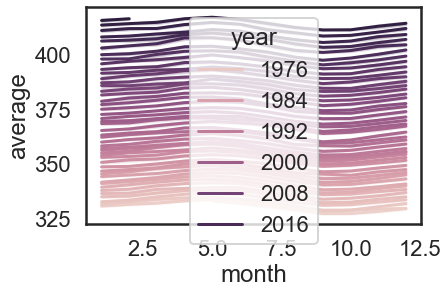

In [24]:
sns.set_context("poster") 
sns.lineplot(data=weekly, x="month", y="average", hue="year");

<a name="model_preperation"></a> 
### Model Preperation

<a name="data_modeling"></a> 
## Data Modeling
Describe and justify the process for analyzing or modeling the data.

Questions to consider:

How did you analyze or model the data?
How did you iterate on your initial approach to make it better?
Why are these choices appropriate given the data and the business problem?

<a name="evaluation"></a> 
## Evaluation
Evaluate how well your work solves the stated business problem.

Questions to consider:

How do you interpret the results?
How well does your model fit your data? How much better is this than your baseline model?
How confident are you that your results would generalize beyond the data you have?
How confident are you that this model would benefit the business if put into use?

<a name="conclusion"></a> 
## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

What would you recommend the business do as a result of this work?
What are some reasons why your analysis might not fully solve the business problem?
What else could you do in the future to improve this project?